## House Price Predictions
Different variables come into play in appraising a house, such as the number of bedrooms, square footage, location, and much more. So, our task here is to build a machine learning model to make reasonably accurate predictions in terms of pricing houses. It would be an opportunity for those in real estate to gain more visibility on the market as a whole. In doing so, this notebook will offer a user-friendly explanation through every step using LIME (Local Interpretable Model-agnostic Explanations) principles.

## Table of Contents
1. Environment set-up
    * Importing Libraries
    * Loading the data
2. Initial Diagnostics
    * Glimpse
    * Descriptive Statitics
    * Target Variable Analysis
    * Predictors Analysis
3. Data Cleaning
    * Missing Values
    * Simple Imputation
    * Grouped Imputation
4. Inquiry Exploration
    * Does bigger means pricier houses?
    * Where is the real estate hotspot?
    * Which miscellaneous feature add the most value?
5. Feature Engineering
    * Outliers - Feature Scaling
    * Categorical Encoding
    * Datetime Variables
    
6. Correlation Analysis

7. Machine Learning set-up
    * Train-test split
    * Cross-validation
    * Dimensionality Reduction

8. Machine Learning - Simple Models

9. Machine Learning - Ensemble Methods

10. Hyperparameter Tuning

11. Model Performance Evaluation
 
12. Final Submission

# 1. Environment Set-up

In [1]:
## Importing Libraries
import warnings
warnings.filterwarnings("ignore")

#Set seed
import random
random.seed(1234)

# Manipulating & Visualizing Data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})

# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Categorical Encoding
import category_encoders as ce

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# ML Models
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model 

# Ensemble Learning
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Performance metrics
import sklearn.metrics as skm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
## Loading the dataset
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2. Initial Diagnostics

In [3]:
## Glimpse of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Takeaway:** From the glimpse above, we could already draw some observations. 
* Our dataset comprises 1460 rows and 80 columns, making it relatively small, so we would not expect the training process o to be as computationally intensive.
* For null values, most columns appear to have no missing values, while null values make up 80% for some of those variables. It indicates that we shall proceed with data cleaning and tidying before doing any statistical analysis or machine learning. 
* In terms of variable type, we have mostly int64, float64, and object. Though 'object' can indicate text or categorical, we will need to investigate further in feature engineering.

In [4]:
## Descriptive Statistics
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Takeaway:** For all 80 variables, the table above captures the basic descriptive statistics showing things like mean, standard deviation, min, max, etc. Commenting on each variable would bring little value to our overall analysis, and so we will zoom on the target variable 'SalePrice'.

In [5]:
# Stats for the target variable
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Takeaway:** The count indicates no null values in the column. The houses in the dataset vary from ~USD34.9k to ~USD755k, with a mean value of ~USD180k. With the standard deviation at ~USD79k, it appears that prices fluctuate pretty significantly, or we may potentially have houses with exorbitant prices (outliers) skewing the data. We will create a histogram to look at the distribution more closely.

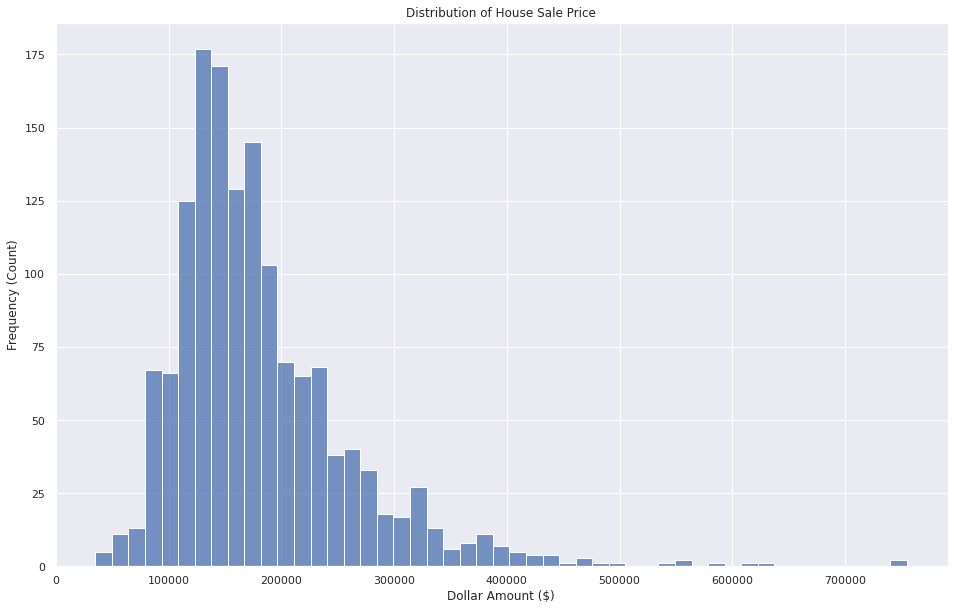

In [6]:
## Feature Variable Analysis
sns.histplot(data=df, x='SalePrice')
plt.xlabel("Dollar Amount ($)")
plt.ylabel("Frequency (Count)")
plt.title("Distribution of House Sale Price")
plt.show()

**Takeaway:** From the histogram above, we can deduct that house sale prices in this dataset have a right-skewed distribution with outliers on the upper end, indicating luxury houses with higher price points. However, most houses appear to fall between ~USD100k and ~USD300k, relatively consistent with real estate markets in the United States.

# 3. Data Cleaning

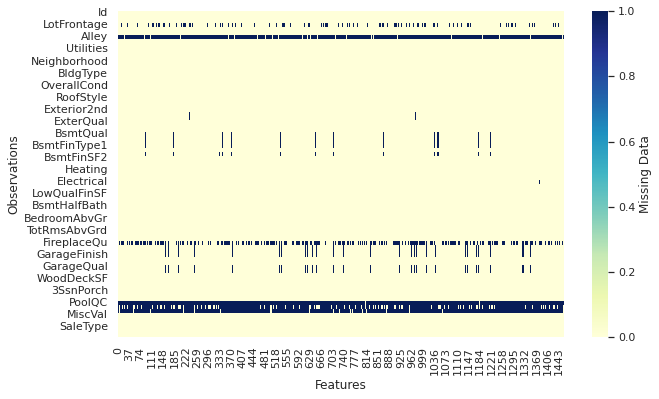

In [7]:
# Visualize missing data
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

**Takeaway:** As the plot shows above, there are indeed null values confirming our observation in the initial diagnostics. Given that not all variables are of the same type or the same proportion of missing values, the cleaning process will attend to each column or group of similar columns.

**Definition:** When it comes to data science, we are constantly dealing with imperfect information, thus murking the waters on the quality of data overall. One of those issues is the recurrence of missing values and requires effective techniques to deal with them. Imputation methods present such an opportunity using strategies to replace null values with statistical measures like mean, mode, or median. More information [here](https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/).

In [8]:
## No. of null values
null_vals = df.isna().sum().sum()

# List of columns with missing values
null_cols = df.columns[df.isna().any()].tolist()

# Reporting back
print("We are missing {:2d} values in our data at given percentages in the following columns:" .format(null_vals))
for i in null_cols:
    col_null = df[i].isnull().sum()
    per_null = col_null / len(df[i])
    print("  - {}: {} ({:.2%})".format(i, col_null, per_null))

We are missing 6965 values in our data at given percentages in the following columns:
  - LotFrontage: 259 (17.74%)
  - Alley: 1369 (93.77%)
  - MasVnrType: 8 (0.55%)
  - MasVnrArea: 8 (0.55%)
  - BsmtQual: 37 (2.53%)
  - BsmtCond: 37 (2.53%)
  - BsmtExposure: 38 (2.60%)
  - BsmtFinType1: 37 (2.53%)
  - BsmtFinType2: 38 (2.60%)
  - Electrical: 1 (0.07%)
  - FireplaceQu: 690 (47.26%)
  - GarageType: 81 (5.55%)
  - GarageYrBlt: 81 (5.55%)
  - GarageFinish: 81 (5.55%)
  - GarageQual: 81 (5.55%)
  - GarageCond: 81 (5.55%)
  - PoolQC: 1453 (99.52%)
  - Fence: 1179 (80.75%)
  - MiscFeature: 1406 (96.30%)


**LotFrontage:** As per the data dictionary, it is the linear feet of street connected to property. It indicates the measurement of a piece of land (lot) often defined by frontage and depth respectively. For instance, an house can be 50 by 150, meaning 50 feet wide (frontage) and 150 feet long. Read more about it [here](https://www.gimme-shelter.com/frontage-50043/). Given that 'LotFrontage' is one of those characteristics all houses have, the null values indicate missing information that cannot just be equal to 0. Since we cannot get back and fetch more data, we will use imputation methods for this column and other ones which may require them.

**Note:** Before proceeding to the imputation, we would like to investigate possible differences in distribution grouped by Lot shape.

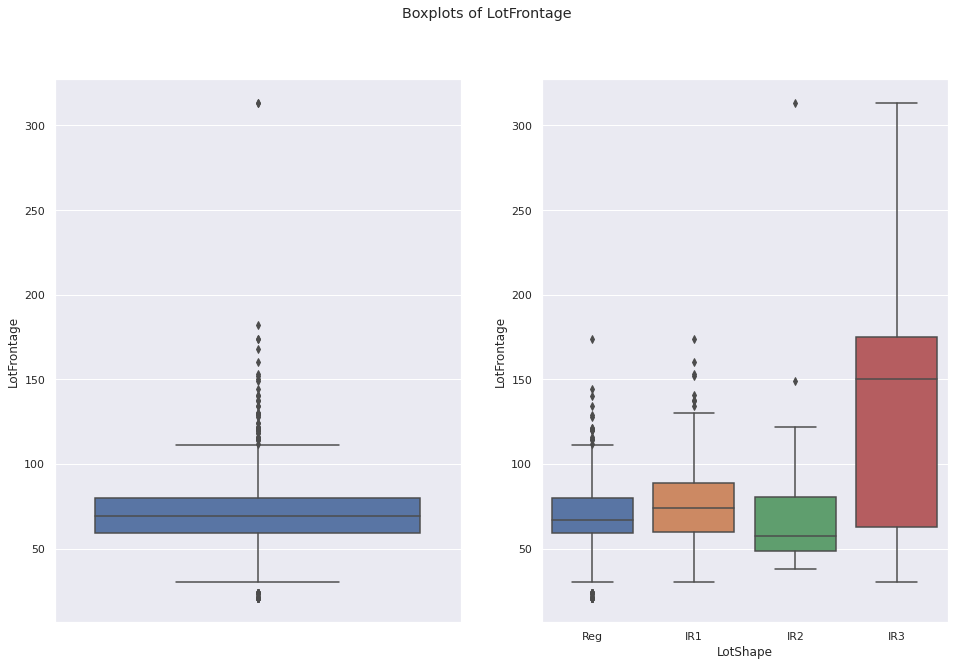

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Boxplots of LotFrontage')
sns.boxplot(ax=ax1, data=df, y="LotFrontage", orient = "v")
sns.boxplot(ax=ax2, data=df, x="LotShape", y="LotFrontage", orient = "v")
plt.show()

In [10]:
print("For all houses' LotFrontage, the mean is {:.2f} and median is {:.2f}".format(df['LotFrontage'].mean(),
                                                               df['LotFrontage'].median()))

For all houses' LotFrontage, the mean is 70.05 and median is 69.00


In [11]:
print("For houses that are: ")
for i in df["LotShape"].unique().tolist():
    df_i = df[df["LotShape"]==i]
    mean_frontage = df_i['LotFrontage'].mean()
    median_frontage = df_i['LotFrontage'].median()
    print(" -{}, mean LotFrontage = {:.2f} and median LotFrontage = {:.2f}".format(i,
                                                                            mean_frontage,
                                                                            median_frontage))

For houses that are: 
 -Reg, mean LotFrontage = 67.04 and median LotFrontage = 67.00
 -IR1, mean LotFrontage = 76.09 and median LotFrontage = 74.00
 -IR2, mean LotFrontage = 76.50 and median LotFrontage = 57.50
 -IR3, mean LotFrontage = 138.43 and median LotFrontage = 150.00


**Takeaway:** The boxplots indicate the presence of outliers in the data with massive and small houses by widths. When broken down by 'LotShape', we also observe a notable difference in those houses categorized as IR3, in other words, of very irregular shape. In light of both the outliers and category differences, we will use the median value grouped by LotShape for the imputation process to ensure consistency in the data.

In [12]:
# Imputation using group by
df['LotFrontage'] = df.groupby('LotShape').LotFrontage.transform(lambda x: x.fillna(x.median()))
df.LotFrontage = df.LotFrontage.round(2)
df['LotFrontage'].isnull().sum()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Alley:** As per the data dictionary, it refers to the type of alley access to property. Given the real estate market in question, it may affect the price more or less and so, the null values are indeed significant with NA indicating that there isn't one. To ensure that it is taken into account, we will rename the NA into the full phrase 'No alley access' and then proceed in encoding this categorical variable.

In [13]:
# Replacing the null values with a significant term
df['Alley'].fillna("No alley access", inplace = True)
df['Alley'].value_counts()

No alley access    1369
Grvl                 50
Pave                 41
Name: Alley, dtype: int64

**Variable Grouping:** It appears that the process in detecting missing valuies actually led to understanding those null values are actually categories significant or equal to 0 per the data dictionary. So, to be more efficient, we will make a list of those columns and the term/value we'll use to replace the na values.

In [14]:
for i in null_cols:
    # Grouping of variables dependent on the presence of a basement
    if 'Bsmt' in i:
        df[i].fillna("No Basement", inplace = True)
        
    # Grouping of variables dependent on the presence of a garage
    elif 'Garage' in i:
        if i == 'GarageYrBlt':
            df[i].fillna(0, inplace = True)
        else:
            df[i].fillna("No Garage", inplace = True)

In [15]:
other_cols_imp = {
    'MasVnrType': 'No Veneer',
    'MasVnrArea': 0, 
    'FireplaceQu': 'No Fireplace', 
    'PoolQC': 'No Pool', 
    'Fence': 'No Fence', 
    'MiscFeature': 'No Misc'
   }

# Grouping of variables dependent on the presence of other amenities
for i, j in other_cols_imp.items():
    df[i].fillna(j, inplace = True)

**Note:** Assuming all houses have an electrical system, we will drop the obersvation having the eltrical system as a null values. 

In [16]:
# Deleting the Electrical 
df.dropna(subset=['Electrical'], inplace=True)

In [17]:
## No. of null values
null_vals = df.isna().sum().sum()

# Reporting back
print("Afer imputation, we have missing {:d} values in our data.".format(null_vals))

Afer imputation, we have missing 0 values in our data.


# 4. Inquiry Exploration

In this section, we will generate various questions to further consolidate our understanding of the problem at hand. It will allow us to guide the machine learning process more attuned to the particular subject matter.

**Question 1:** Do bigger houses always translate into higher prices?

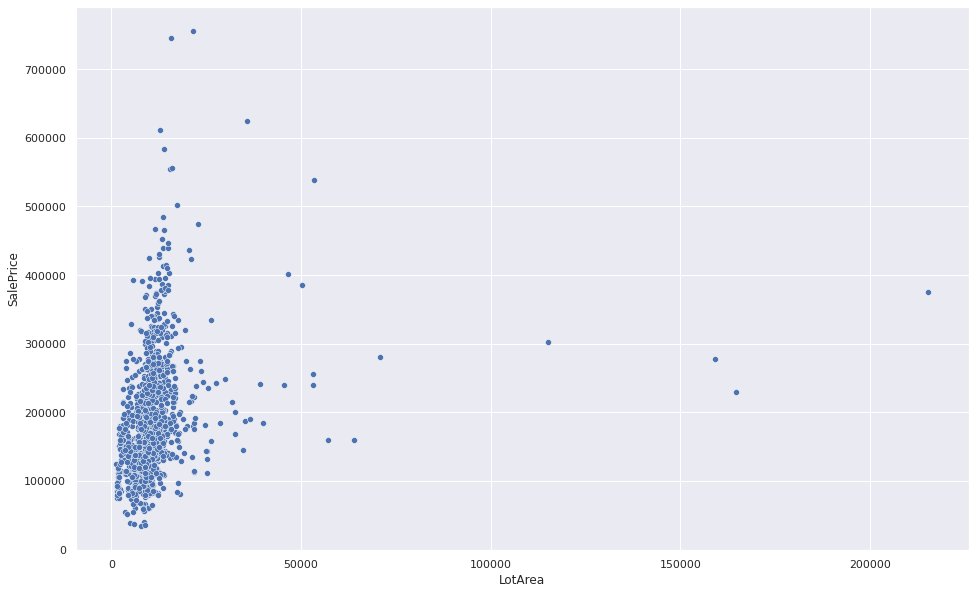

In [18]:
## Scatterplot between lotArea and SalePrice
sns.scatterplot(data=df, x='LotArea', y='SalePrice')
plt.show()

**Takeaway:** From the scatterplot above, there is very little evidence indicating that bigger houses are ultimiately pricier. As noted in the diagnostics, the 80 initial variables show how the house valuation process is multi-dimensional.

**Question 2:** Where is the real estate hotspot?

In [19]:
# Which neighborhood registers the most sales?
total = df['Neighborhood'].value_counts()[0]
per = df['Neighborhood'].value_counts(normalize=True)[0]
neigh_name = pd.DataFrame(df['Neighborhood'].value_counts()).index[0]
print("{} has the most houses sales with {} making up {:.2%} of all sales.".format(neigh_name, 
                                                                                  total, per))

NAmes has the most houses sales with 225 making up 15.42% of all sales.


In [20]:
# Which neighborhood registers the sales with the highest price tags?
df_grouped = pd.DataFrame(df.groupby('Neighborhood')['SalePrice'].sum())
df_sorted = df_grouped.sort_values('SalePrice', ascending=False)
df_sorted['per_total'] = (df_sorted['SalePrice'] / df_sorted['SalePrice'].sum())

neigh_name = df_sorted.index[0]
total = df_sorted['SalePrice'][0]
per = df_sorted['per_total'][0]
print("{} has the highest cumulative sales amount of ${:,} making up {:.2%} of all transactions.".format(
                                                                                                    neigh_name, 
                                                                                                    total, per))

NAmes has the highest cumulative sales amount of $32,815,593 making up 12.43% of all transactions.


**Note:** As per the data dictionary, NAmes refers to Iowan city of North Ames. 

**Question 3:** What miscellaneous feature add the most value?

In [21]:
# Which miscellaneous feature is the most prevalent?
total = df['MiscFeature'].value_counts()[1]
misc_name = pd.DataFrame(df['MiscFeature'].value_counts()).index[1]
print("For houses with miscellaneous features, {} is the most prevalent in {} houses.".format(misc_name, total))

For houses with miscellaneous features, Shed is the most prevalent in 49 houses.


In [22]:
# Calculating the value added
misc = df[df['MiscFeature'] == 'Shed']['MiscVal']
sale = df[df['MiscFeature'] == 'Shed']['SalePrice']
avg_value_added = np.average(misc)
per_sale = np.average(misc/sale)
print("{} brings ${:.2f} of value added making {:.2%} of the house sale price on average.".format(
                                                                                                misc_name, 
                                                                                                avg_value_added,
                                                                                                per_sale))

Shed brings $697.84 of value added making 0.48% of the house sale price on average.


# 5. Feature Engineering

**Feature Scaling:** When dealing with data, we are working with different types of which required adpated pre-processing before applying any machine learning techniques. In our content, we perform feature scaling to standardize only the values in continuous numerical variables. Read more [here](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35).

In [23]:
# Filter numeric columns
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
           'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

scaler = StandardScaler().fit(df[num_vars].values)
df[num_vars] = scaler.transform(df[num_vars].values)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,-0.240163,-0.207125,Pave,No alley access,Reg,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,2,2008,WD,Normal,208500
1,2,20,RL,0.429345,-0.091909,Pave,No alley access,Reg,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,5,2007,WD,Normal,181500
2,3,60,RL,-0.106262,0.073401,Pave,No alley access,IR1,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,9,2008,WD,Normal,223500
3,4,70,RL,-0.463332,-0.096918,Pave,No alley access,IR1,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,2,2006,WD,Abnorml,140000
4,5,60,RL,0.607880,0.374967,Pave,No alley access,IR1,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,12,2008,WD,Normal,250000


**Categorical feature encoding** ensures that variables with categories/groupings are transformed into numerical inputs for the predictive modeling phase. The categorical variables are also subdivided as:
- binary (two possible outcomes)
- cardinal (no meaningful order) 
- ordinal (meaningful order) 

Read more [here](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/).

In [24]:
# Encoding binary categorical variables
binary = ['CentralAir']

# Applying binary encoder
binenc = ce.BinaryEncoder(cols = binary, return_df = True)
bin_df = binenc.fit_transform(df)  
bin_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,-0.240163,-0.207125,Pave,No alley access,Reg,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,2,2008,WD,Normal,208500
1,2,20,RL,0.429345,-0.091909,Pave,No alley access,Reg,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,5,2007,WD,Normal,181500
2,3,60,RL,-0.106262,0.073401,Pave,No alley access,IR1,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,9,2008,WD,Normal,223500
3,4,70,RL,-0.463332,-0.096918,Pave,No alley access,IR1,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,2,2006,WD,Abnorml,140000
4,5,60,RL,0.607880,0.374967,Pave,No alley access,IR1,Lvl,AllPub,...,-0.068715,No Pool,No Fence,No Misc,-0.087718,12,2008,WD,Normal,250000


In [25]:
# List of nominal categorical variables
cardinal = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
            'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
            'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 
            'Functional', 'GarageType', 'MiscFeature', 'SaleType', 
            'SaleCondition']


# Applying one-hot encoder 
ohe = ce.OneHotEncoder(cols = cardinal, use_cat_names=True, return_df = True)
df_card_enc = ohe.fit_transform(bin_df)  
df_card_enc.head()

,Id,MSSubClass_60.0,MSSubClass_20.0,MSSubClass_70.0,MSSubClass_50.0,MSSubClass_190.0,MSSubClass_45.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_30.0,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SalePrice
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,208500
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,181500
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,223500
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,250000


In [26]:
# Encoding cardinal categorical variables
ordinal_cols_mapping = [ 
    {"col" : 'LotShape', "mapping": {'Reg':0, 'IR1': 1, 'IR2':2, 'IR3':3}},
    {"col" : 'LandContour', "mapping": {'Low':0, 'Lvl':1, 'Bnk':2, 'HLS':3}},
    {"col" : 'Utilities', "mapping": {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3}},
    {"col" : 'LandSlope', "mapping": {'Gtl': 0, 'Mod': 1, 'Sev':2}},
    {"col" : 'OverallQual', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}},
    {"col" : 'OverallCond', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}},
    {"col" : 'ExterQual', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'ExterCond', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'BsmtQual', "mapping": {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'BsmtCond', "mapping": {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},   
    {"col" : 'BsmtExposure', "mapping": {'No Basement':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}},
    {"col" : 'BsmtFinType1', "mapping": {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}}, 
    {"col" : 'BsmtFinType2', "mapping": {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}},  
    {"col" : 'HeatingQC', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'KitchenQual', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
    {"col" : 'FireplaceQu', "mapping": {'No Fireplace':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'GarageFinish', "mapping": {'No Garage':0, 'Unf':1, 'RFn':2, 'Fin':3}},
    {"col" : 'GarageQual', "mapping": {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'GarageCond', "mapping": {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'PavedDrive', "mapping": {'N':0, 'P':1, 'Y':2}}, 
    {"col" : 'PoolQC', "mapping": {'No Pool':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
    {"col" : 'Fence', "mapping":{'No Fence':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}}
]

# Applying ordinal encoder
ordenc = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)
df_ord_enc = ordenc.fit_transform(df_card_enc)  
df_ord_enc.head()

,Id,MSSubClass_60.0,MSSubClass_20.0,MSSubClass_70.0,MSSubClass_50.0,MSSubClass_190.0,MSSubClass_45.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_30.0,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SalePrice
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,208500
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,181500
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,223500
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,250000


**Datetime Variables:** There are variables denoting dates and thus, may hold significance and impact our target variable: the house's sale price. 

Based on research, we thought that the most sensible option would be to transform the datetime variables into ordinal categories in twofold:
 - Direct encoding of 'MoSold' and 'YrSold' having 12 and 5 pre-defined categories that are the 12 months and 5 years respectively during which the houses in the dataset were sold.
 - Binning of 'YearRemodAdd' and 'YearBuilt' into 6 categories of 10 and 20 years of interval respectively before proceding to ordinal encoding as well.

In [27]:
# Binning date variables in time intervals
df_ord_enc['YearRemodAdd'] = pd.cut(df_ord_enc['YearRemodAdd'], bins=6, precision=0).astype(str)
df_ord_enc['YearRemodAdd'].value_counts()

(2000.0, 2010.0]    496
(1990.0, 2000.0]    285
(1950.0, 1960.0]    284
(1970.0, 1980.0]    159
(1960.0, 1970.0]    149
(1980.0, 1990.0]     86
Name: YearRemodAdd, dtype: int64

In [28]:
df_ord_enc['YearBuilt'] = pd.cut(df_ord_enc['YearBuilt'], bins=6, precision=0).astype(str)
df_ord_enc['YearBuilt'].value_counts()

(1987.0, 2010.0]    564
(1964.0, 1987.0]    329
(1941.0, 1964.0]    294
(1918.0, 1941.0]    187
(1895.0, 1918.0]     71
(1872.0, 1895.0]     14
Name: YearBuilt, dtype: int64

In [29]:
df_ord_enc['GarageYrBlt'] = pd.cut(df_ord_enc[df_ord_enc['GarageYrBlt'] != 0]['GarageYrBlt']
                                   , bins=6, precision=0).astype(str)
df_ord_enc['GarageYrBlt'].fillna("No Garage", inplace = True)
df_ord_enc['GarageYrBlt'].value_counts()

(1992.0, 2010.0]    572
(1955.0, 1973.0]    320
(1973.0, 1992.0]    245
(1937.0, 1955.0]    146
No Garage            81
(1918.0, 1937.0]     78
(1900.0, 1918.0]     17
Name: GarageYrBlt, dtype: int64

In [30]:
# Datetime variable - ordinal encoding
date_cols_mapping = [ 
    {"col" : 'YrSold', "mapping": {2006:0, 2007: 1, 2008:2, 
                                   2009:3, 2010:4}},
    
    {"col" : 'MoSold', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 
                                   8:7, 9:8, 10:9, 11:10, 12:11}},
    
    {"col" : 'YearRemodAdd', "mapping": {'(1950.0, 1960.0]':0, '(1960.0, 1970.0]':1,
                                         '(1970.0, 1980.0]':2, '(1980.0, 1990.0]':3,
                                         '(1990.0, 2000.0]':4, '(2000.0, 2010.0]':5}},
    
    {"col" : 'YearBuilt', "mapping": {'(1872.0, 1895.0]':0, '(1895.0, 1918.0]':1,
                                         '(1918.0, 1941.0]':2, '(1941.0, 1964.0]':3,
                                         '(1964.0, 1987.0]':4, '(1987.0, 2010.0]':5}},
    
    {"col" : 'GarageYrBlt', "mapping": {'No Garage':0, '(1900.0, 1918.0]':1,
                                        '(1918.0, 1937.0]':2, '(1937.0, 1955.0]':3,
                                        '(1955.0, 1973.0]':4, '(1973.0, 1992.0]':5,
                                        '(1992.0, 2010.0]':6}},
]

# Applying label encoder
ordenc = ce.OrdinalEncoder(mapping = date_cols_mapping, return_df = True)
df_final = ordenc.fit_transform(df_ord_enc)  
df_final.head()

,Id,MSSubClass_60.0,MSSubClass_20.0,MSSubClass_70.0,MSSubClass_50.0,MSSubClass_190.0,MSSubClass_45.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_30.0,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SalePrice
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,208500
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,181500
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,223500
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,250000


# 4. Correlation Analysis

**Note:** Given that we have 240 columns, it would be quite computationally intensive to display the entire correlation matrix and visualize it for user-friendly analysis. As a result, we will only filter out relatively and highly correlated relationship with coefficient between 0.7 and 1 (non-inclusive to avoid pairs of identical variables).

In [31]:
## Strongest Relationships
matrix_corr = df_final.corr()
matrix_corr = np.round(matrix_corr.unstack(), 2)
strong_rel = matrix_corr[(abs(matrix_corr) >= 0.7) & (abs(matrix_corr) != 1.00)]
strong_rel

MSSubClass_60.0        HouseStyle_2Story        0.76
MSSubClass_20.0        HouseStyle_1Story        0.76
MSSubClass_50.0        HouseStyle_1.5Fin        0.94
MSSubClass_190.0       BldgType_2fmCon          0.98
MSSubClass_45.0        HouseStyle_1.5Unf        0.93
                                                ... 
SaleType_New           SaleCondition_Partial    0.99
SaleCondition_Partial  SaleType_WD             -0.77
                       SaleType_New             0.99
SalePrice              OverallQual              0.79
                       GrLivArea                0.71
Length: 106, dtype: float64

**Takeaway:** We detected 98 relationships of which we assume 40 to be unique pairs having a correlation coefficients greather than 0.75. Given that our focus is on the sale of the house, we will filter out only relationships related to variables with 'Sale' as a prefix.

In [32]:
# Focus on variables directly related to the sale
matrix_corr = df_final.corr()
matrix_sale = matrix_corr.filter(regex='^Sale',axis=1)
matrix_sale = np.round(matrix_sale.unstack(), 2)
strong_rel_sale = matrix_sale[(abs(matrix_sale) >= 0.7) & (abs(matrix_sale) != 1.00)]
strong_rel_sale

SaleType_WD            SaleType_New            -0.77
                       SaleCondition_Partial   -0.77
SaleType_New           SaleType_WD             -0.77
                       SaleCondition_Partial    0.99
SaleCondition_Partial  SaleType_WD             -0.77
                       SaleType_New             0.99
SalePrice              OverallQual              0.79
                       GrLivArea                0.71
dtype: float64

**Takeaway:** Among the two detected, 'OverallQual' appears to be a key variable that is highly correlated to the sale price of the house. It probably falls inline with our expectations in terms of the valuation process of a house; indeed, it requires good to excellent quality to be desired on the real estate market.

# 7. Machine Learning Set-Up

First off, we need to prepapre the data to feed the machine learning models. In doing so, we first separate the features and target variables and then proceed in creating train and testing set for model training and performance evaluation.

In [33]:
# Splitting features & target variable
X = df_final.drop(['SalePrice'], axis=1).values
y = df_final['SalePrice'].values
y_log = np.log(y)

In [34]:
## Training Testing Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                                    test_size=1/3, 
                                                    random_state=0)

# 8. Machine Learning - Simple Models

This section will leverage the powerful sci-kit-learn package to build multiple models with little to no parameter tuning for comparison. We will only use the cross-validation error on our training dataset to avoid any data leakage.

In [35]:
# Dictionary to store model structures
models = {'MLR': linear_model.LinearRegression(),
          'Ridge': linear_model.Ridge(),
          'Lasso': linear_model.Lasso(),
          'Elastic Net': linear_model.ElasticNet(),
          'Decision tree': DecisionTreeRegressor()
        }

**Note:** Our goal is predict house prices which are all non-negative values; however, our machine learning will likely also results in some negative values. To mitiagte this issue, we performed logarithmic transformation on our target values and then obtain the error rate accordingly. Read more [here](https://stats.stackexchange.com/questions/360399/how-to-constrain-gradient-boosting-predictions-to-be-non-negative.).

In [36]:
# Model Building & performance evaluation
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

for name, model in models.items():
    model_errs = []
    for train_index, test_index in kf.split(X_train):
        X_train_k = X_train[train_index] 
        y_train_k = y_train[train_index]
        model.fit(X_train_k, y_train_k)
        pred_log = model.predict(X_train_k)
        # pred = np.exp(pred_log)
        rmse = skm.mean_squared_error(y_train_k, pred_log, squared=False) 
        model_errs.append(rmse)
        # report performance
    print('{} - RMSLE: {:.5f} ({:.5f})' .format(name, np.mean(model_errs), 
                                               np.std(model_errs)))

MLR - RMSLE: 0.08077 (0.00328)
Ridge - RMSLE: 0.09245 (0.00314)
Lasso - RMSLE: 0.40108 (0.00786)
Elastic Net - RMSLE: 0.40108 (0.00786)
Decision tree - RMSLE: 0.00000 (0.00000)


# 10. Machine Learning - Ensemble Methods

This section will extend our work in machine learning to incorporate ensemble methods. We generated simple models and compared the scores, which appear satisfactory; however, we may want more stability and minor variation in our predictive algorithm; it is where ensemble techniques come in. Most often, they act as a 'superposer' of multiple models throughout various ways and thus, bolster their predictive power. Further Information [here](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/). 

In [37]:
# Stacking multiple models
estimators = [
    ('MLR', linear_model.LinearRegression()),
    ('Ridge', linear_model.Ridge())
]
# Dictionary to store ensemble model structures
ensemble_models = {
    'RF': RandomForestRegressor(),
    'XGBoost': BaggingRegressor(base_estimator=xgb.XGBRegressor()),
    'Stacking': StackingRegressor(estimators=estimators,
                                   final_estimator=DecisionTreeRegressor())
}

In [38]:
# Model Building & performance evaluation
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

for name, model in ensemble_models.items():
    model_errs = []
    for train_index, test_index in kf.split(X_train):
        X_train_k = X_train[train_index] 
        y_train_k = y_train[train_index]
        model.fit(X_train_k, y_train_k)
        pred_log = model.predict(X_train_k)
        #pred = np.exp(pred_log)
        rmsle = skm.mean_squared_error(y_train_k, pred_log, squared=False) 
        model_errs.append(rmsle)
        # report performance
    print('{} - RMSLE: {:.5f} ({:.5f})' .format(name, np.mean(model_errs), 
                                               np.std(model_errs)))

RF - RMSLE: 0.05556 (0.00119)
XGBoost - RMSLE: 0.05542 (0.00369)
Stacking - RMSLE: 0.14507 (0.00721)


**Takeaway:** In this instance, our best model is the XGBoost having the lowest RMSE for the log values of house prices. We will proceed in doing the hyperparameter tuning with the random Forest given that they offer more robust and reliable results than the simple ones. 

# 10. Hyperparameter Tuning

This section will walk through a process to find the best possible models given a set of parameters. In machine learning, we name it hyperparameter tuning during which the algorithm search for the set of optimal hyperarameters driving the metric as high (or low depending the case scenario) as possible. Further information [here](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/). 

In [39]:
## Random Search
# Define the model
model = RandomForestRegressor()
# define search space
rf_space = {
   'n_estimators': range(20, 100, 20),
   'max_depth': range(3, 15, 3),
   'min_samples_split': [2, 5, 10], 
   'min_samples_leaf': [1, 2, 4]
}

In [40]:
search = GridSearchCV(estimator=model, param_grid=rf_space, 
                      cv=2, scoring='neg_root_mean_squared_error')
search.fit(X_train, y_train)
print('RF - RMSE of log values: {:.5f}' .format(search.best_score_))
print('with best parameters: {}.\n' .format(search.best_params_))

RF - RMSE of log values: -0.15238
with best parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 80}.



In [41]:
search = RandomizedSearchCV(estimator=model, param_distributions=rf_space, 
                            cv=2, scoring='neg_root_mean_squared_error')
search.fit(X_train, y_train)
print('RF - RMSE of log values: {:.5f}' .format(search.best_score_))
print('with best parameters: {}.\n' .format(search.best_params_))

RF - RMSE of log values: -0.15519
with best parameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 12}.



# 11. Model Performance Evaluation

This section will build on everything we've done throughout this notebook and evaluate the best model using RMSE of log values.

In [42]:
# Running on testing set
tree = RandomForestRegressor(n_estimators=60, max_depth=12, 
                              min_samples_leaf=2, min_samples_split=5)
tree.fit(X_train, y_train)
y_pred_log = tree.predict(X_test)
rmsle = skm.mean_squared_error(y_test, y_pred_log, squared=False) 
# report performance
print('RF - RMSE of log values: {:.5f}' .format(rmsle))

RF - RMSE of log values: 0.14489


# 12. Final Submission

In [43]:
# Loading the dataset
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [44]:
# List of columns with missing values
null_cols = test_df.columns[test_df.isna().any()].tolist()

# Imputation using group by
test_df['LotFrontage'] = test_df.groupby('LotShape').LotFrontage.transform(lambda x: x.fillna(x.median()))
test_df.LotFrontage = test_df.LotFrontage.round(2)
test_df['LotFrontage'].isnull().sum()
test_df.head()

# Replacing the null values with a significant term
test_df['Alley'].fillna("No alley access", inplace = True)
test_df['Alley'].value_counts()

# Grouping of variables dependent on the presence of a basement
for i in null_cols:
    if 'Bsmt' in i:
        test_df[i].fillna("No Basement", inplace = True)
        
# Grouping of variables dependent on the presence of a garage
for i in null_cols:
    if 'Garage' in i and i != 'GarageYrBlt':
        test_df[i].fillna("No Garage", inplace = True)
    elif i == 'GarageYrBlt':
        test_df[i].fillna(0, inplace = True)
        
other_cols_imp = {
    'MasVnrType': 'No Veneer',
    'MasVnrArea': 0, 
    'FireplaceQu': 'No Fireplace', 
    'PoolQC': 'No Pool', 
    'Fence': 'No Fence', 
    'MiscFeature': 'No Misc'
   }

# Grouping of variables dependent on the presence of other amenities
for i, j in other_cols_imp.items():
    test_df[i].fillna(j, inplace = True)

# Deleting the Electrical 
test_df.dropna(subset=['Electrical'], inplace=True)

In [45]:
## No. of null values
null_vals = test_df.isna().sum().sum()

# Reporting back
print("We are missing {:2d} values in our data at given percentages in the following columns:" .format(null_vals))
for i in null_cols:
    col_null = test_df[i].isnull().sum()
    per_null = col_null / len(test_df[i])
    print("  - {}: {} ({:.2%})".format(i, col_null, per_null))

We are missing 12 values in our data at given percentages in the following columns:
  - MSZoning: 4 (0.27%)
  - LotFrontage: 0 (0.00%)
  - Alley: 0 (0.00%)
  - Utilities: 2 (0.14%)
  - Exterior1st: 1 (0.07%)
  - Exterior2nd: 1 (0.07%)
  - MasVnrType: 0 (0.00%)
  - MasVnrArea: 0 (0.00%)
  - BsmtQual: 0 (0.00%)
  - BsmtCond: 0 (0.00%)
  - BsmtExposure: 0 (0.00%)
  - BsmtFinType1: 0 (0.00%)
  - BsmtFinSF1: 0 (0.00%)
  - BsmtFinType2: 0 (0.00%)
  - BsmtFinSF2: 0 (0.00%)
  - BsmtUnfSF: 0 (0.00%)
  - TotalBsmtSF: 0 (0.00%)
  - BsmtFullBath: 0 (0.00%)
  - BsmtHalfBath: 0 (0.00%)
  - KitchenQual: 1 (0.07%)
  - Functional: 2 (0.14%)
  - FireplaceQu: 0 (0.00%)
  - GarageType: 0 (0.00%)
  - GarageYrBlt: 0 (0.00%)
  - GarageFinish: 0 (0.00%)
  - GarageCars: 0 (0.00%)
  - GarageArea: 0 (0.00%)
  - GarageQual: 0 (0.00%)
  - GarageCond: 0 (0.00%)
  - PoolQC: 0 (0.00%)
  - Fence: 0 (0.00%)
  - MiscFeature: 0 (0.00%)
  - SaleType: 1 (0.07%)


In [46]:
#Given how few null values are left, we will drop those 12 rows.
test_df.dropna(subset=null_cols, inplace=True)

## No. of null values
null_vals = test_df.isna().sum().sum()

# Reporting back
print("We are missing {:2d} values in our data at given percentages in the following columns:" .format(null_vals))

We are missing  0 values in our data at given percentages in the following columns:


In [47]:
# # Filter numeric columns
# df = test_df
# num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
#            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
#            'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#             'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# scaler = StandardScaler().fit(df[num_vars].values)
# df[num_vars] = scaler.transform(df[num_vars].values)
# df.head()

# # Encoding binary categorical variables
# binary = ['CentralAir']

# # Applying binary encoder
# binenc = ce.BinaryEncoder(cols = binary, return_df = True)
# bin_df = binenc.fit_transform(df)  
# bin_df.head()

# # List of nominal categorical/cardinal variables
# cardinal = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig', 
#             'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
#             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
#             'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 
#             'Functional', 'GarageType', 'MiscFeature', 'SaleType', 
#             'SaleCondition']

# # Applying one-hot encoder 
# ohe = ce.OneHotEncoder(cols = cardinal, use_cat_names=True, return_df = True)
# df_card_enc = ohe.fit_transform(bin_df)  
# df_card_enc.head()

# # Encoding ordinal variables
# ordinal_cols_mapping = [ 
#     {"col" : 'LotShape', "mapping": {'Reg':0, 'IR1': 1, 'IR2':2, 'IR3':3}},
#     {"col" : 'LandContour', "mapping": {'Low':0, 'Lvl':1, 'Bnk':2, 'HLS':3}},
#     {"col" : 'Utilities', "mapping": {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3}},
#     {"col" : 'LandSlope', "mapping": {'Gtl': 0, 'Mod': 1, 'Sev':2}},
#     {"col" : 'OverallQual', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}},
#     {"col" : 'OverallCond', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}},
#     {"col" : 'ExterQual', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
#     {"col" : 'ExterCond', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
#     {"col" : 'BsmtQual', "mapping": {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
#     {"col" : 'BsmtCond', "mapping": {'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},   
#     {"col" : 'BsmtExposure', "mapping": {'No Basement':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}},
#     {"col" : 'BsmtFinType1', "mapping": {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}}, 
#     {"col" : 'BsmtFinType2', "mapping": {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}},  
#     {"col" : 'HeatingQC', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
#     {"col" : 'KitchenQual', "mapping": {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}},
#     {"col" : 'FireplaceQu', "mapping": {'No Fireplace':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
#     {"col" : 'GarageFinish', "mapping": {'No Garage':0, 'Unf':1, 'RFn':2, 'Fin':3}},
#     {"col" : 'GarageQual', "mapping": {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
#     {"col" : 'GarageCond', "mapping": {'No Garage':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
#     {"col" : 'PavedDrive', "mapping": {'N':0, 'P':1, 'Y':2}}, 
#     {"col" : 'PoolQC', "mapping": {'No Pool':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}},
#     {"col" : 'Fence', "mapping":{'No Fence':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}}
# ]

# # Applying ordinal encoder
# ordenc = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)
# df_ord_enc = ordenc.fit_transform(df_card_enc)  
# df_ord_enc.head()

# # Binning date variables in time intervals
# df_ord_enc['YearRemodAdd'] = pd.cut(df_ord_enc['YearRemodAdd'], bins=6, precision=0).astype(str)
# df_ord_enc['YearRemodAdd'].value_counts()

# df_ord_enc['YearBuilt'] = pd.cut(df_ord_enc['YearBuilt'], bins=6, precision=0).astype(str)
# df_ord_enc['YearBuilt'].value_counts()

# df_ord_enc['GarageYrBlt'] = pd.cut(df_ord_enc[df_ord_enc['GarageYrBlt'] != 0]['GarageYrBlt']
#                                    , bins=6, precision=0).astype(str)
# df_ord_enc['GarageYrBlt'].fillna("No Garage", inplace = True)
# df_ord_enc['GarageYrBlt'].value_counts()

# # Datetime variable - ordinal encoding
# date_cols_mapping = [ 
#     {"col" : 'YrSold', "mapping": {2006:0, 2007: 1, 2008:2, 
#                                    2009:3, 2010:4}},
    
#     {"col" : 'MoSold', "mapping": {1: 0, 2: 1, 3:2, 4:3, 5:4, 6:5, 7:6, 
#                                    8:7, 9:8, 10:9, 11:10, 12:11}},
    
#     {"col" : 'YearRemodAdd', "mapping": {'(1950.0, 1960.0]':0, '(1960.0, 1970.0]':1,
#                                          '(1970.0, 1980.0]':2, '(1980.0, 1990.0]':3,
#                                          '(1990.0, 2000.0]':4, '(2000.0, 2010.0]':5}},
    
#     {"col" : 'YearBuilt', "mapping": {'(1872.0, 1895.0]':0, '(1895.0, 1918.0]':1,
#                                          '(1918.0, 1941.0]':2, '(1941.0, 1964.0]':3,
#                                          '(1964.0, 1987.0]':4, '(1987.0, 2010.0]':5}},
    
#     {"col" : 'GarageYrBlt', "mapping": {'No Garage':0, '(1900.0, 1918.0]':1,
#                                         '(1918.0, 1937.0]':2, '(1937.0, 1955.0]':3,
#                                         '(1955.0, 1973.0]':4, '(1973.0, 1992.0]':5,
#                                         '(1992.0, 2010.0]':6}},
# ]

# # Applying label encoder
# ordenc = ce.OrdinalEncoder(mapping = date_cols_mapping, return_df = True)
# test_df_final = ordenc.fit_transform(df_ord_enc)  
# test_final.head()

In [48]:
# Defining our orignal model
# final_model = RandomForestRegressor(n_estimators=60, max_depth=12, 
#                               min_samples_leaf=2, min_samples_split=5)
# final_model.fit(X, y)
# pred_log = final_model.predict(test_df)
# pred = np.exp(pred_log)
# sub = pd.DataFrame({'ID': ids, 'target': pred})
# sub.to_csv('submission.csv', index=False)